In [47]:
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [48]:
#Propose a new step (using a symmetric Gaussian proposal density centered at the old sample)
def ProposedStep(oldsamp,sigmaprop,D):
    newsamp = oldsamp + np.random.normal(0.,sigmaprop,D)
    return newsamp

#Hastings ratio
def HastingsRatio(newsamp,oldsamp,priorrange,PDF,*Pargs):
    a= newsamp[2]*215.032 #au to solar radii
    r_p= 0.10049*newsamp[0] #Jupiter to solar radius
    r_s=2.336
    i= newsamp[1]*np.pi/180 #deg2rad
    b2= ((a/r_s)*np.cos(i))**2
    delta= (r_p/r_s)**2
    sqr1=(1+delta)**2-(a*np.cos(i)/r_s)**2
    sqr2=(1-delta)**2-(a*np.cos(i)/r_s)**2
    
    #This is to accept the new samples given the following conditions hold. Or else no transit.
    if sqr1<0 or sqr2<0 or b2>1:
        acc=False
        return acc,oldsamp
    
    if not ((np.array([p1 - p2 for p1, p2 in zip(newsamp, np.transpose(priorrange)[:][0])])>0).all() \
            and (np.array([p2 - p1 for p1, p2 in zip(newsamp,np.transpose(priorrange)[:][1])])>0).all()):
        acc = False
        return acc, oldsamp # make sure the samples are in the desired range
    
    newprob = PDF(newsamp,*Pargs)
    oldprob = PDF(oldsamp,*Pargs)
    if newprob >= oldprob:
        acc = True
        return acc, newsamp
    else:
        prob = newprob/oldprob
        acc = np.random.choice([True,False],p=[prob,1.-prob])
        return acc, acc*newsamp + (1. - acc)*oldsamp 

#Function that runs the chain
def MCMC(PDF,D,Nsteps,priorrange,sigmaprop,*Pargs):
    #Draw a random starting point
    oldsamp=np.array([np.random.uniform(priorrange[d][0],priorrange[d][1]) for d in range(D)])
    
    #Count the number of accepted samples
    count = 0 
    
    #Store all samples
    samples = [oldsamp]
    
    for i in range(Nsteps):
        newsamp = ProposedStep(oldsamp,sigmaprop,D) #Propose a new sample
        acc, newsamp = HastingsRatio(newsamp,oldsamp,priorrange,PDF,*Pargs) #decide whether or not to accept it
        samples.append(newsamp) #Add the sample to the list of samples
        if acc:
            count += 1
        oldsamp = newsamp #Move to the new sample
        
    #compute the acceptance ratio    
    AR = 1.*count/Nsteps 
    return np.array(samples), AR




In [49]:
def piecewise_function(tT,tf,d,m, x):
    #Function to define a piece-wisely defined function for the basic light curve.
    y=[]
    for i in range(len(x)):
        if x[i]<(0.5-tT/2):
            y.append(1)
        elif (0.5-tT/2)<=x[i]<(0.5-tf/2):
            y.append(-m*x[i]+1+m*(0.5-tT/2))
        elif (0.5-tf/2)<=x[i]<(0.5+tf/2):
            y.append(1-d)
        elif (0.5+tf/2)<=x[i]<(0.5+tT/2):
            y.append(m*x[i]+1-m*(0.5+tT/2))
        elif x[i]>=(0.5+tT/2):
            y.append(1)
    
    arr=np.array(y)
    return arr

In [50]:
def limb_factor(t,tf,b):
    #Function to calculate the limb darkening factor for some given time 't' of the transit
    u=0.65
    factor=0
    x= 2*np.sqrt(1-b**2)*(t-0.5)/tf
    y= np.sqrt(x**2+b**2)
    theta= np.pi*y/2
    factor= 1-u*(1-np.cos(theta))
    return factor

In [51]:
#Simulate a set of Nobs observations
Nobs = 500
sigma = 0.00005 #the standard deviation of the Gaussian noise, equivalent to the PSD of the detector

#Create a noise realizations
np.random.seed(10)
n = np.random.normal(0.,sigma,Nobs)

#Observation times
t = np.linspace(0,1,Nobs)

In [52]:
def light_curve1(r_p, i, a, t):
    e=0
    r_s=2.336 #au to solar radius
    r_p= 0.10049*r_p #Jupiter to solar radius
    delta= (r_p/r_s)**2
    a= a*215.032 #au to solar radii
    i=i*np.pi/180 #deg2rad
    b= (a/r_s)*np.cos(i)
    
    sqr1=(1+delta)**2-(a*np.cos(i)/r_s)**2
    sqr2= (1-delta)**2-(a*np.cos(i)/r_s)**2
    t_Tc= ((1/np.pi*(r_s/a))*np.sqrt(sqr1))
    
    #The above transit time is for circular orbits. Now, to calculate for eccentric orbits.
    temp1= 1-(b)**2
    temp2= 1-(e)**2
    temp3= 1+e*np.sin(270*np.pi/180)
    t_T= t_Tc*np.sqrt(temp1*temp2)/temp3
    
    t_f=t_T*np.sqrt(sqr2)/np.sqrt(sqr1)
    
    #Function to plot the light curve with limb darkening.
    d=limb_factor(0.5-t_f/2,t_f,b)*delta
    lum= 1-d #lum at the start of the transit
    trans_time= (t_T-t_f)/2
    m= (d)/trans_time
    
    y = piecewise_function(t_T,t_f,d,m,t)
    
    for i in range(len(t)):
        if (0.5-t_f/2)<t[i]<(0.5+t_f/2):
            y[i]= y[i]+d -limb_factor(t[i],t_f,b)*delta
            
    #returns an array of flux values
    return y

    

In [53]:
test= light_curve1(1.026,88.7,0.1097,t) #radius of star (Jupiter radii), inclination (degrees), semi major axis(au)

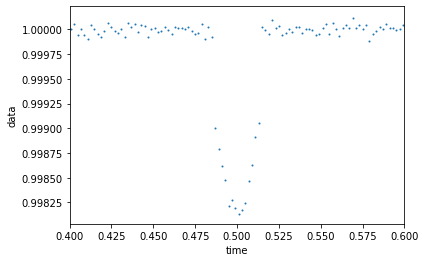

In [54]:
#Generate the data
data = test+n


plt.scatter(t,data, s=1)

plt.xlabel('time')
plt.ylabel('data')
plt.xlim(0.4,0.6)
plt.show()

In [55]:
def posterior(samp,d,t):
    #r_s = samp[0] # radius of star
    r_p = samp[0] # radius of planet
    #p = samp[1] # period
    i= samp[1] #inclination
    a= samp[2] #semi major axis
    #e= samp[5] #eccentricity
    
    #print(len(d))
    
    temp=light_curve1(r_p,i,a,t)
    #print(len(temp))
    res = (d-temp)**2 # residual
    
    likelihood = np.exp(-0.5*(res.sum()/sigma**2)) 
    # sigma here is the standard deviation of the noise which we assume 
    #we know, similar to the PSD of the gravitational wave detector
    
    prior=1 #Let's assume uniform priors for all parameters
    
    # Change the form of the prior and reanalyze the data. For example use the following prior for the amplitude
    #prior= 1./x
    
    
    return prior*likelihood

In [56]:
np.random.seed(18)
Nsteps = 200000 # length of the chain
sigmaprop = 0.01 # standard deviation of the proposal density
D=3 # dimensionality of the problem
priorrange=np.array([[0.5,1.5],[87,90],[0,0.15]])
samples, AR = MCMC(posterior,D,Nsteps,priorrange,sigmaprop,data,t) # run the chain
print('acceptance ratio:', AR)

acceptance ratio: 0.067125


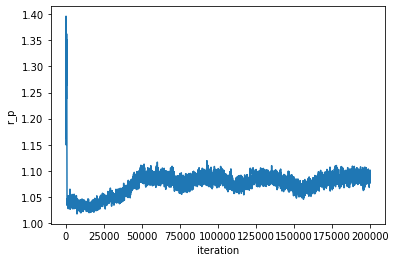

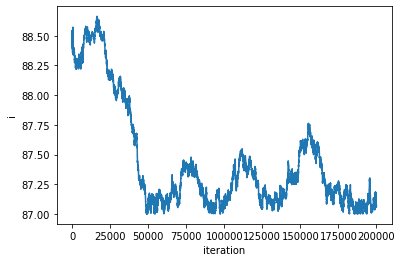

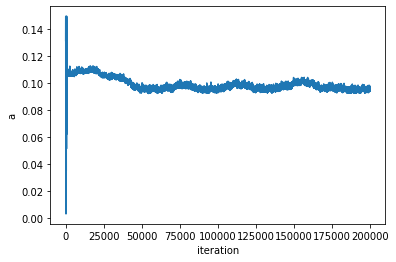

In [57]:
plt.plot(samples[:,0])
plt.xlabel('iteration')
plt.ylabel('r_p')
plt.show()


plt.plot(samples[:,1])
plt.xlabel('iteration')
plt.ylabel('i')
plt.show()

plt.plot(samples[:,2])
plt.xlabel('iteration')
plt.ylabel('a')
plt.show()



In [58]:
#After abour 25000 samples, the chains seem to have settled
burnin = 50000
samples = samples[burnin:]

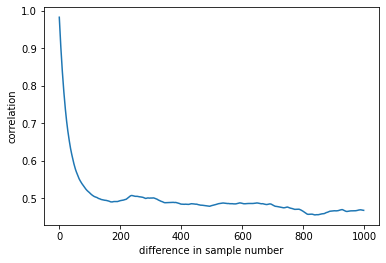

In [59]:
xmean=(np.mean(samples[:,0]))
xvar=(np.var(samples[:,0]))
ACL=np.array([(((samples[h:,0]-xmean)*(samples[:-h,0]-xmean)).sum())/(len(samples[:,0])-h)/xvar for h in range(1,1000)])                              

plt.plot(ACL)
plt.xlabel(r'difference in sample number')
plt.ylabel(r'correlation')
plt.show()

In [60]:
corrlength = 400 #where the correlation drops to about 0.5
independentsamples = samples[::corrlength]
print(independentsamples.shape)
print(1.*independentsamples.shape[0]/Nsteps)

(376, 3)
0.00188


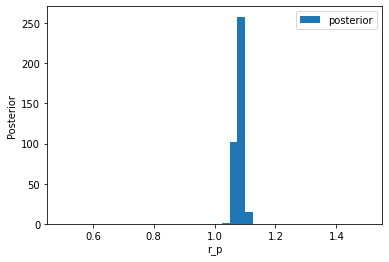

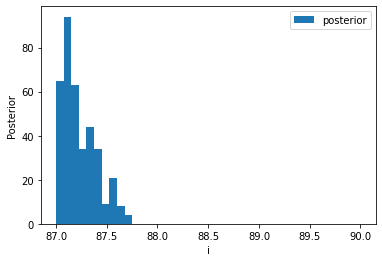

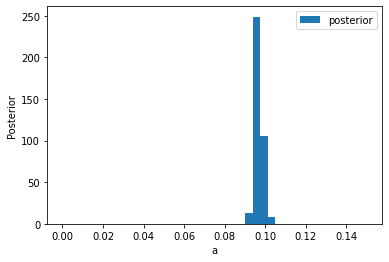

In [61]:
x_values = independentsamples[:,0]

plt.hist(x_values,range=(0.5,1.5),bins=40,label='posterior')
#plt.axvline(A,color='r',label='injected')
plt.xlabel('r_p')
plt.ylabel('Posterior')
plt.legend()
plt.show()

y_values = independentsamples[:,1]

plt.hist(y_values,range=(87,90),bins=40,label='posterior')
#plt.axvline(f,color='r',label='injected')
plt.xlabel('i')
plt.ylabel('Posterior')
plt.legend()
plt.show()

z_values = independentsamples[:,2]

plt.hist(z_values,range=(0,0.15),bins=40,label='posterior')
#plt.axvline(phi,color='r',label='injected')
plt.xlabel('a')
plt.ylabel('Posterior')
plt.legend()
plt.show()